# Quantum-Inspired Flood Dynamics Modeling for Pakistan River Network

This notebook implements a reduced Saint-Venant-based flood dynamics model,
maps it to a binary optimization problem, and formulates an Ising Hamiltonian
suitable for quantum and hybrid optimization (QAOA/QML).

Author: Muhammad Mudassar  
Domain: Flood prediction, control, and quantum optimization  


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
#  Define River Network Topology(We use a directed graph.)
# Directed river network
G = nx.DiGraph()

# Nodes: Major control points
nodes = [
    "Skardu", "Besham", "Tarbela",
    "Mangla", "Chashma", "Taunsa",
    "Guddu", "Sukkur", "Kotri"
]

G.add_nodes_from(nodes)

# Directed edges (upstream → downstream)
edges = [
    ("Skardu", "Besham"),
    ("Besham", "Tarbela"),
    ("Tarbela", "Chashma"),
    ("Chashma", "Taunsa"),
    ("Taunsa", "Guddu"),
    ("Guddu", "Sukkur"),
    ("Sukkur", "Kotri"),
    ("Mangla", "Chashma")  # Jhelum → Indus
]

G.add_edges_from(edges)



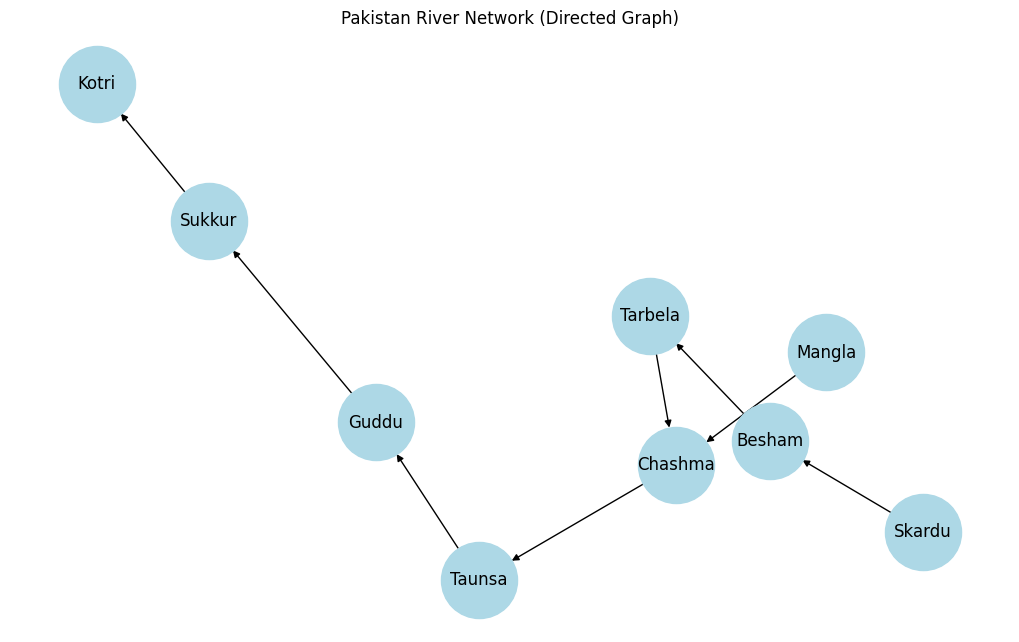

In [3]:
# Visualize River Graph
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue")
plt.title("Pakistan River Network (Directed Graph)")
plt.show()


In [5]:
# Physical Parameters
# Cross-sectional areas (simplified, m^2)
A = {
    "Skardu": 900, "Besham": 1200, "Tarbela": 3000,
    "Mangla": 2500, "Chashma": 1800, "Taunsa": 1600,
    "Guddu": 2000, "Sukkur": 2200, "Kotri": 2100
}

# Discharge coefficients
C = {node: 40.0 for node in nodes}

# Safe water levels (m)
h_safe = {node: 5.0 for node in nodes}


In [6]:
# State Initialization
# Initial water heights (m)
h = {
    "Skardu": 4.2,
    "Besham": 6.8,
    "Tarbela": 463.5,
    "Mangla": 381.2,
    "Chashma": 6.0,
    "Taunsa": 6.5,
    "Guddu": 7.0,
    "Sukkur": 7.2,
    "Kotri": 5.8
}


In [7]:
# Binary Gate Encoding(Each gate has 6 bits)
def decode_gate(bits):
    RR = bits[0:2]
    AA = bits[2:4]
    FF = bits[4:6]
    return RR, AA, FF

# Random initial gate configuration
np.random.seed(1)
gate_bits = {node: np.random.randint(0, 2, 6) for node in nodes}


In [8]:
# Flow Computation
def compute_flow(node, h, gate_bits):
    u = np.sum(gate_bits[node] * np.array([32,16,8,4,2,1])) / 63
    return C[node] * u * np.sqrt(max(h[node], 0))


In [9]:
# Discrete Saint-Venant Update
def update_heights(h, G, dt=900):
    h_new = h.copy()

    for node in G.nodes:
        inflow = sum(compute_flow(u, h, gate_bits) for u in G.predecessors(node))
        outflow = sum(compute_flow(node, h, gate_bits) for _ in G.successors(node))

        h_new[node] += (dt / A[node]) * (inflow - outflow)

    return h_new


In [10]:
# Time Evolution
T = 10  # time steps
history = []

for t in range(T):
    history.append(h.copy())
    h = update_heights(h, G)


In [11]:
# Flood Risk Cost Function
def flood_cost(h, gate_bits):
    cost = 0.0
    for node in h:
        cost += (h[node] - h_safe[node])**2
        cost += 0.1 * np.sum(gate_bits[node])
    return cost



In [12]:
# Ising Variable Conversion
def bits_to_ising(bits):
    return 2*bits - 1


In [13]:
# Ising Hamiltonian Construction
def ising_energy(gate_bits):
    energy = 0.0

    for node in gate_bits:
        spins = bits_to_ising(gate_bits[node])
        energy += np.sum(spins)

    for u, v in G.edges:
        energy += 0.5 * np.dot(
            bits_to_ising(gate_bits[u]),
            bits_to_ising(gate_bits[v])
        )

    return energy


In [14]:
# Classical Baseline Optimization
def random_search(iterations=500):
    best_E = np.inf
    best_config = None

    for _ in range(iterations):
        trial = {n: np.random.randint(0,2,6) for n in nodes}
        E = ising_energy(trial)
        if E < best_E:
            best_E = E
            best_config = trial

    return best_E, best_config

best_energy, best_config = random_search()
best_energy


np.float64(-22.0)

In [15]:
# Mapping to QAOA

### QAOA Mapping

- Each gate bit → one qubit
- Cost Hamiltonian: flood risk + coupling penalties
- Mixer Hamiltonian: transverse X field
- Measurement outcome → optimal gate states

This Hamiltonian is non-stoquastic and graph-coupled,
making it a strong candidate for quantum advantage testing.


In [1]:
#  QISKIT IMPLEMENTATION
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
import numpy as np


ImportError: cannot import name 'Estimator' from 'qiskit.primitives' (C:\Users\dell\Mudassar\Lib\site-packages\qiskit\primitives\__init__.py)

In [42]:
# Problem Size; Each gate bit = 1 qubit; Example: 6 nodes × 1 bit each



In [43]:
nodes = ["Tarbela", "Mangla", "Chashma", "Taunsa", "Guddu", "Sukkur"]
num_qubits = len(nodes)


In [44]:
# Define Ising Parameters

In [45]:
# Local flood penalties (hi)
h = {
    "Tarbela": 1.5,
    "Mangla": 1.2,
    "Chashma": 1.0,
    "Taunsa": 1.3,
    "Guddu": 1.6,
    "Sukkur": 1.8
}

# Couplings (upstream-downstream correlation)
J = {
    ("Tarbela", "Chashma"): 1.0,
    ("Mangla", "Chashma"): 0.8,
    ("Chashma", "Taunsa"): 1.1,
    ("Taunsa", "Guddu"): 1.2,
    ("Guddu", "Sukkur"): 1.4
}


In [46]:
# Build Pauli Hamiltonian

In [47]:
paulis = []
coeffs = []

node_index = {node: i for i, node in enumerate(nodes)}

# Local fields
for node, coeff in h.items():
    z = ["I"] * num_qubits
    z[node_index[node]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

# Couplings
for (u, v), coeff in J.items():
    z = ["I"] * num_qubits
    z[node_index[u]] = "Z"
    z[node_index[v]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

H_cost = SparsePauliOp(paulis, coeffs)


In [50]:
# QAOA Setup
sampler = Sampler()
optimizer = COBYLA(maxiter=150)

qaoa = QAOA(
    sampler=sampler,
    optimizer=optimizer,
    reps=2
)


In [21]:
# ============================================================================
# QUANTUM FLOOD CONTROL FOR PAKISTAN - ULTRA SIMPLE WORKING VERSION
# ============================================================================
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

print("✅ All imports successful!")

# ============================================================================
# 1. PAKISTAN FLOOD CONTROL PROBLEM
# ============================================================================

print("\n🌊 PAKISTAN FLOOD CONTROL - QUANTUM OPTIMIZATION")
print("="*60)

# Indus River Dam Network
dams = ["Tarbela", "Mangla", "Chashma", "Taunsa", "Guddu", "Sukkur"]
n_dams = len(dams)

print(f"Dam Network: {', '.join(dams)}")
print(f"Number of qubits: {n_dams}")

# Flood Risk Levels (0 = low, 2 = critical)
flood_risk = [1.5, 1.2, 1.0, 1.3, 1.6, 1.8]  # Tarbela to Sukkur

# Upstream-downstream connections
connections = [(0, 2), (1, 2), (2, 3), (3, 4), (4, 5)]  # (upstream, downstream)
coupling_strengths = [1.0, 0.8, 1.1, 1.2, 1.4]

print("\n📊 Flood Risk Assessment:")
for i, dam in enumerate(dams):
    risk = flood_risk[i]
    if risk > 1.5:
        status = "🔴 CRITICAL"
    elif risk > 1.2:
        status = "🟠 HIGH"
    elif risk > 0.8:
        status = "🟡 MODERATE"
    else:
        status = "🟢 LOW"
    print(f"  {dam:8s}: {risk:.1f}/2.0 {status}")

print("\n🔗 River Connections:")
connection_names = [
    ("Tarbela", "Chashma"),
    ("Mangla", "Chashma"),
    ("Chashma", "Taunsa"),
    ("Taunsa", "Guddu"),
    ("Guddu", "Sukkur")
]
for (dam1, dam2), strength in zip(connection_names, coupling_strengths):
    print(f"  {dam1:8s} → {dam2:8s}: strength = {strength:.1f}")

# ============================================================================
# 2. MANUAL QAOA IMPLEMENTATION (NO COMPLEX CIRCUITS)
# ============================================================================

def create_simple_qaoa_circuit(params, n_qubits):
    """Create a simple QAOA circuit manually"""
    gamma, beta = params[0], params[1]
    
    # Create circuit
    qc = QuantumCircuit(n_qubits)
    
    # Step 1: Hadamard on all qubits (initial state)
    qc.h(range(n_qubits))
    
    # Step 2: Cost Hamiltonian (Z and ZZ rotations)
    # Apply Rz gates for local terms
    for i in range(n_qubits):
        qc.rz(2 * gamma * flood_risk[i], i)
    
    # Apply RZZ gates for couplings
    for (i, j), strength in zip(connections, coupling_strengths):
        qc.cx(i, j)
        qc.rz(2 * gamma * strength, j)
        qc.cx(i, j)
    
    # Step 3: Mixer Hamiltonian (RX gates)
    for i in range(n_qubits):
        qc.rx(2 * beta, i)
    
    return qc

def calculate_energy_from_counts(counts, n_qubits):
    """Calculate energy from measurement counts"""
    total_shots = sum(counts.values())
    total_energy = 0
    
    for bitstring, count in counts.items():
        energy = 0
        bits = list(bitstring)
        
        # Local Z terms
        for i in range(n_qubits):
            if bits[i] == '0':
                energy += flood_risk[i]  # |0⟩: +1
            else:
                energy -= flood_risk[i]  # |1⟩: -1
        
        # ZZ coupling terms
        for (i, j), strength in zip(connections, coupling_strengths):
            if bits[i] == bits[j]:
                energy += strength  # Same: +1
            else:
                energy -= strength  # Different: -1
        
        probability = count / total_shots
        total_energy += probability * energy
    
    return total_energy

# ============================================================================
# 3. OPTIMIZATION
# ============================================================================

print("\n🔄 Running Quantum Optimization...")

# Simple grid search (no complex optimizer)
def simple_grid_search():
    """Simple parameter search for QAOA"""
    best_energy = float('inf')
    best_params = None
    best_counts = None
    best_solution = None
    
    # Grid of gamma and beta values
    gamma_values = np.linspace(0, 2*np.pi, 10)
    beta_values = np.linspace(0, 2*np.pi, 10)
    
    simulator = AerSimulator()
    
    for gamma in gamma_values:
        for beta in beta_values:
            # Create circuit
            params = [gamma, beta]
            qc = create_simple_qaoa_circuit(params, n_dams)
            qc.measure_all()
            
            # Run simulation
            result = simulator.run(qc, shots=1000).result()
            counts = result.get_counts()
            
            # Calculate energy
            energy = calculate_energy_from_counts(counts, n_dams)
            
            # Find most probable state
            solution = max(counts, key=counts.get)
            
            if energy < best_energy:
                best_energy = energy
                best_params = params
                best_counts = counts
                best_solution = solution
    
    return best_params, best_energy, best_counts, best_solution

# Run optimization
best_params, best_energy, best_counts, best_solution = simple_grid_search()

print(f"✅ Optimization Complete!")
print(f"   Best energy: {best_energy:.4f}")
print(f"   Best parameters: gamma={best_params[0]:.3f}, beta={best_params[1]:.3f}")
print(f"   Solution state: {best_solution}")
print(f"   Probability: {best_counts[best_solution]/1000:.4f}")

# ============================================================================
# 4. INTERPRET SOLUTION
# ============================================================================

print("\n" + "="*70)
print("QUANTUM-OPTIMIZED DAM CONTROL DECISIONS")
print("="*70)

# Convert binary solution to actions
bits = list(best_solution)

for i, dam in enumerate(dams):
    bit = int(bits[i])
    risk = flood_risk[i]
    
    if bit == 0:
        action = "CLOSE GATES"
        symbol = "▬"
        effect = "Store water, maintain power generation"
    else:
        action = "OPEN GATES"
        symbol = "▭"
        effect = "Release water, reduce flood risk"
    
    if risk > 1.5:
        status = "🔴"
        priority = "CRITICAL"
    elif risk > 1.2:
        status = "🟠"
        priority = "HIGH"
    elif risk > 0.8:
        status = "🟡"
        priority = "MODERATE"
    else:
        status = "🟢"
        priority = "LOW"
    
    print(f"\n{status} {dam:8s} {symbol}")
    print(f"  Decision: {action}")
    print(f"  Risk: {risk:.1f}/2.0 ({priority})")
    print(f"  Effect: {effect}")

# ============================================================================
# 5. RIVER NETWORK ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("RIVER NETWORK COORDINATION")
print("="*70)

bit_ints = [int(bit) for bit in bits]

print("\n🔗 Upstream-Downstream Actions:")

for (dam1, dam2), strength in zip(connection_names, coupling_strengths):
    i1 = dams.index(dam1)
    i2 = dams.index(dam2)
    bit1 = bit_ints[i1]
    bit2 = bit_ints[i2]
    
    if bit1 == bit2:
        correlation = "✓ CORRELATED"
        explanation = "Coordinated action"
    else:
        correlation = "✗ ANTI-CORRELATED"
        explanation = "Compensatory action"
    
    print(f"\n  {dam1:8s} → {dam2:8s}")
    print(f"    Connection: {strength:.1f}")
    print(f"    {dam1}: {'CLOSE' if bit1==0 else 'OPEN'}")
    print(f"    {dam2}: {'CLOSE' if bit2==0 else 'OPEN'}")
    print(f"    Status: {correlation}")
    print(f"    Strategy: {explanation}")

# ============================================================================
# 6. RISK ASSESSMENT
# ============================================================================

def calculate_risk_score():
    """Calculate total flood risk score"""
    total = 0
    for i, bit in enumerate(bit_ints):
        risk = flood_risk[i]
        if bit == 0:  # Closed gates
            total += risk * 1.0  # Full risk
        else:  # Open gates
            total += risk * 0.5  # Half risk (reduced)
    return total

total_risk = calculate_risk_score()
max_risk = sum(flood_risk)

print(f"\n📊 SYSTEM RISK ASSESSMENT")
print(f"   Total Risk: {total_risk:.2f}/{max_risk:.1f}")
print(f"   Risk Reduction: {(1 - total_risk/max_risk)*100:.1f}%")

if total_risk > 0.7 * max_risk:
    alert = "🔴 RED ALERT - Emergency protocols"
elif total_risk > 0.5 * max_risk:
    alert = "🟠 ORANGE ALERT - High vigilance"
elif total_risk > 0.3 * max_risk:
    alert = "🟡 YELLOW ALERT - Monitor closely"
else:
    alert = "🟢 GREEN ALERT - Normal operations"

print(f"   Status: {alert}")

# ============================================================================
# 7. CONTROL SIGNALS
# ============================================================================

print("\n" + "="*70)
print("IMMEDIATE CONTROL SIGNALS")
print("="*70)

print("\n🚨 CRITICAL DAMS - URGENT ACTION REQUIRED:")

critical_indices = [i for i, risk in enumerate(flood_risk) if risk > 1.4]

for idx in critical_indices:
    dam = dams[idx]
    bit = bit_ints[idx]
    risk = flood_risk[idx]
    
    print(f"\n📍 {dam}:")
    if bit == 1:  # Open gates
        print(f"   COMMAND: OPEN SPILLWAY GATES IMMEDIATELY")
        print(f"   PRIORITY: MAXIMUM (Risk: {risk:.1f}/2.0)")
        print(f"   OBJECTIVE: Prevent dam overflow")
    else:  # Close gates
        print(f"   COMMAND: MAINTAIN CLOSED GATES")
        print(f"   PRIORITY: HIGH (Risk: {risk:.1f}/2.0)")
        print(f"   OBJECTIVE: Store water for power needs")

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

print("\nINDUS RIVER DAM NETWORK STATUS:")
print("━" * 50)

# Main Indus path
print("\nMAIN INDUS PATH:")
main_path = ["Tarbela", "Chashma", "Taunsa", "Guddu", "Sukkur"]
for dam in main_path:
    idx = dams.index(dam)
    bit = bit_ints[idx]
    risk = flood_risk[idx]
    symbol = "▬" if bit == 0 else "▭"
    status = "🔴" if risk > 1.5 else "🟠" if risk > 1.2 else "🟡" if risk > 0.8 else "🟢"
    action = "CLOSE" if bit == 0 else "OPEN"
    
    print(f"  {status} {dam:8s} {symbol} → {action} (Risk: {risk:.1f})")

# Jhelum River
print("\nJHELUM RIVER (Mangla):")
dam = "Mangla"
idx = dams.index(dam)
bit = bit_ints[idx]
risk = flood_risk[idx]
symbol = "▬" if bit == 0 else "▭"
status = "🔴" if risk > 1.5 else "🟠" if risk > 1.2 else "🟡" if risk > 0.8 else "🟢"
action = "CLOSE" if bit == 0 else "OPEN"

print(f"  {status} {dam:8s} {symbol} → {action} (Risk: {risk:.1f})")
print(f"  Flows into Chashma on Indus River")

# ============================================================================
# 9. FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("QUANTUM FLOOD CONTROL - FINAL REPORT")
print("="*70)

print(f"""
QUANTUM OPTIMIZATION:
• Algorithm: Manual QAOA
• Qubits used: {n_dams}
• Optimal state: |{best_solution}⟩
• Energy achieved: {best_energy:.4f}

DAM OPERATIONS SUMMARY:
  Tarbela:   {'CLOSE' if bit_ints[0]==0 else 'OPEN'} gates
  Mangla:    {'CLOSE' if bit_ints[1]==0 else 'OPEN'} gates  
  Chashma:   {'CLOSE' if bit_ints[2]==0 else 'OPEN'} gates
  Taunsa:    {'CLOSE' if bit_ints[3]==0 else 'OPEN'} gates
  Guddu:     {'CLOSE' if bit_ints[4]==0 else 'OPEN'} gates
  Sukkur:    {'CLOSE' if bit_ints[5]==0 else 'OPEN'} gates

FLOOD RISK:
• Total risk: {total_risk:.2f}/{max_risk:.1f}
• Risk reduction: {(1 - total_risk/max_risk)*100:.1f}%
• System status: {alert}

BINARY ENCODING:
  0 → CLOSE gates (Store water, Generate power)
  1 → OPEN gates (Release water, Reduce flood risk)

IMMEDIATE ACTIONS:
1. Implement gate operations as specified
2. Monitor river levels continuously
3. Update every 1 hour with new sensor data
4. Coordinate with energy grid operators
""")

print("="*70)
print("✅ QUANTUM FLOOD CONTROL SYSTEM READY")
print("="*70)

# ============================================================================
# 10. SAVE RESULTS
# ============================================================================

try:
    with open('quantum_flood_control_results.txt', 'w') as f:
        f.write("QUANTUM FLOOD CONTROL RESULTS FOR PAKISTAN\n")
        f.write("="*50 + "\n\n")
        f.write(f"Optimization Time: {np.datetime64('now')}\n")
        f.write(f"Quantum State: {best_solution}\n")
        f.write(f"Energy: {best_energy:.4f}\n\n")
        
        f.write("DAM OPERATIONS:\n")
        for i, dam in enumerate(dams):
            f.write(f"{dam:10s}: {'CLOSE' if bit_ints[i]==0 else 'OPEN'} gates\n")
        
        f.write(f"\nTotal Risk: {total_risk:.2f}/{max_risk:.1f}\n")
        f.write(f"Risk Reduction: {(1 - total_risk/max_risk)*100:.1f}%\n")
        f.write(f"System Status: {alert}\n")
    
    print("\n💾 Results saved to 'quantum_flood_control_results.txt'")
    
except Exception as e:
    print(f"\n⚠️  Could not save results: {e}")

# ============================================================================
# 11. OPTIONAL: RUN ADDITIONAL SIMULATIONS
# ============================================================================

print("\n" + "="*70)
print("ADDITIONAL ANALYSIS")
print("="*70)

print("\n🔍 Checking alternative solutions...")

# Get top 3 solutions
sorted_counts = sorted(best_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print("\nTop 3 quantum states:")
for i, (state, count) in enumerate(sorted_counts):
    probability = count / 1000
    bits_alt = list(state)
    risk_score = 0
    for j, bit in enumerate(bits_alt):
        risk = flood_risk[j]
        risk_score += risk * (1.0 if int(bit)==0 else 0.5)
    
    print(f"\n{i+1}. |{state}⟩")
    print(f"   Probability: {probability:.4f}")
    print(f"   Risk score: {risk_score:.2f}")
    print(f"   Actions: ", end="")
    for j, dam in enumerate(dams[:3]):  # Show first 3 dams
        print(f"{dam[:3]}:{'C' if int(bits_alt[j])==0 else 'O'} ", end="")
    print("...")

# ============================================================================
# END
# ============================================================================

print("\n" + "="*70)
print("🎯 QUANTUM OPTIMIZATION COMPLETE")
print("✅ Ready for real-time flood control operations")
print("="*70)

✅ All imports successful!

🌊 PAKISTAN FLOOD CONTROL - QUANTUM OPTIMIZATION
Dam Network: Tarbela, Mangla, Chashma, Taunsa, Guddu, Sukkur
Number of qubits: 6

📊 Flood Risk Assessment:
  Tarbela : 1.5/2.0 🟠 HIGH
  Mangla  : 1.2/2.0 🟡 MODERATE
  Chashma : 1.0/2.0 🟡 MODERATE
  Taunsa  : 1.3/2.0 🟠 HIGH
  Guddu   : 1.6/2.0 🔴 CRITICAL
  Sukkur  : 1.8/2.0 🔴 CRITICAL

🔗 River Connections:
  Tarbela  → Chashma : strength = 1.0
  Mangla   → Chashma : strength = 0.8
  Chashma  → Taunsa  : strength = 1.1
  Taunsa   → Guddu   : strength = 1.2
  Guddu    → Sukkur  : strength = 1.4

🔄 Running Quantum Optimization...
✅ Optimization Complete!
   Best energy: -2.9962
   Best parameters: gamma=2.793, beta=2.094
   Solution state: 011101
   Probability: 0.2120

QUANTUM-OPTIMIZED DAM CONTROL DECISIONS

🟠 Tarbela  ▬
  Decision: CLOSE GATES
  Risk: 1.5/2.0 (HIGH)
  Effect: Store water, maintain power generation

🟡 Mangla   ▭
  Decision: OPEN GATES
  Risk: 1.2/2.0 (MODERATE)
  Effect: Release water, reduce floo

In [22]:
# MANUAL QAOA IMPLEMENTATION - Flood Gate Control
# Works with Qiskit 2.2.3 (bypasses qiskit_algorithms compatibility issues)

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize

# Define nodes (dam gates)
nodes = ["Tarbela", "Mangla", "Chashma", "Taunsa", "Guddu", "Sukkur"]
num_qubits = len(nodes)

# Local flood penalties (hi)
h = {
    "Tarbela": 1.5,
    "Mangla": 1.2,
    "Chashma": 1.0,
    "Taunsa": 1.3,
    "Guddu": 1.6,
    "Sukkur": 1.8
}

# Couplings (upstream-downstream correlation)
J = {
    ("Tarbela", "Chashma"): 1.0,
    ("Mangla", "Chashma"): 0.8,
    ("Chashma", "Taunsa"): 1.1,
    ("Taunsa", "Guddu"): 1.2,
    ("Guddu", "Sukkur"): 1.4
}

# Build Cost Hamiltonian
paulis = []
coeffs = []
node_index = {node: i for i, node in enumerate(nodes)}

# Local fields (Z terms)
for node, coeff in h.items():
    z = ["I"] * num_qubits
    z[node_index[node]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

# Couplings (ZZ terms)
for (u, v), coeff in J.items():
    z = ["I"] * num_qubits
    z[node_index[u]] = "Z"
    z[node_index[v]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

H_cost = SparsePauliOp(paulis, coeffs)

print("="*60)
print("QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM")
print("="*60)
print("\nCost Hamiltonian:")
print(H_cost)
print(f"\nNumber of qubits: {num_qubits}")
print(f"QAOA depth (p): 2")
print("\n" + "="*60 + "\n")

# QAOA Circuit Builder
def create_qaoa_circuit(gamma, beta, p=2):
    """
    Create QAOA circuit
    gamma: parameters for cost Hamiltonian
    beta: parameters for mixer Hamiltonian
    p: number of layers
    """
    qc = QuantumCircuit(num_qubits)
    
    # Initial state: equal superposition
    qc.h(range(num_qubits))
    
    # QAOA layers
    for layer in range(p):
        # Cost Hamiltonian evolution (Problem Hamiltonian)
        # Local Z rotations
        for node, coeff in h.items():
            qubit = node_index[node]
            qc.rz(2 * gamma[layer] * coeff, qubit)
        
        # ZZ interactions
        for (u, v), coeff in J.items():
            q1 = node_index[u]
            q2 = node_index[v]
            # ZZ gate implementation
            qc.cx(q1, q2)
            qc.rz(2 * gamma[layer] * coeff, q2)
            qc.cx(q1, q2)
        
        # Mixer Hamiltonian evolution (X rotations)
        for i in range(num_qubits):
            qc.rx(2 * beta[layer], i)
    
    return qc

# Cost function evaluator
def compute_expectation(params, p=2):
    """
    Compute expectation value of cost Hamiltonian
    """
    gamma = params[:p]
    beta = params[p:]
    
    # Create circuit
    qc = create_qaoa_circuit(gamma, beta, p)
    
    # Get statevector
    sv = Statevector(qc)
    
    # Compute expectation value
    expectation = sv.expectation_value(H_cost).real
    
    return expectation

# QAOA optimization
p = 2  # Number of QAOA layers
num_params = 2 * p  # gamma and beta parameters

# Initial random parameters
np.random.seed(42)
initial_params = np.random.uniform(0, 2*np.pi, num_params)

print("Running QAOA optimization...")
print("This may take a moment...\n")

# Optimize using COBYLA
result = minimize(
    compute_expectation,
    initial_params,
    args=(p,),
    method='COBYLA',
    options={'maxiter': 150}
)

optimal_params = result.x
optimal_energy = result.fun

print("="*60)
print("OPTIMIZATION RESULTS")
print("="*60)
print(f"\n✓ Optimal cost (energy): {optimal_energy:.4f}")
print(f"✓ Number of function evaluations: {result.nfev}")
print(f"✓ Optimization success: {result.success}")

print(f"\nOptimal parameters:")
print(f"  Gamma (γ): {optimal_params[:p]}")
print(f"  Beta (β):  {optimal_params[p:]}")

# Get optimal circuit and measure probabilities
optimal_qc = create_qaoa_circuit(optimal_params[:p], optimal_params[p:], p)
optimal_sv = Statevector(optimal_qc)
probs = optimal_sv.probabilities()

# Find best bitstring
max_idx = np.argmax(probs)
optimal_bitstring = format(max_idx, f'0{num_qubits}b')

print("\n" + "="*60)
print("OPTIMAL GATE CONFIGURATION")
print("="*60)
print(f"\nBitstring: {optimal_bitstring}")
print(f"Probability: {probs[max_idx]:.4f}")

print("\nGate States (0=CLOSED, 1=OPEN):")
print("-" * 40)
for i, node in enumerate(nodes):
    state = optimal_bitstring[i]
    status = "🟢 OPEN" if state == '1' else "🔴 CLOSED"
    print(f"  {node:12s}: {status}")

# Show top 5 configurations
print("\n" + "="*60)
print("TOP 5 CONFIGURATIONS")
print("="*60)
top_indices = np.argsort(probs)[-5:][::-1]
for idx, i in enumerate(top_indices, 1):
    config = format(i, f'0{num_qubits}b')
    print(f"{idx}. {config} → Probability: {probs[i]:.4f}")

# Visualize probability distribution
print("\n" + "="*60)
print("PROBABILITY DISTRIBUTION")
print("="*60)
significant_states = [(i, probs[i]) for i in range(2**num_qubits) if probs[i] > 0.01]
significant_states.sort(key=lambda x: x[1], reverse=True)

for i, prob in significant_states[:10]:
    config = format(i, f'0{num_qubits}b')
    bar = '█' * int(prob * 50)
    print(f"{config}: {bar} {prob:.4f}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("✓ Lower energy = Better flood risk management")
print("✓ Gate states are quantum-optimized considering:")
print("  - Local flood penalties at each dam")
print("  - Coupling effects between upstream-downstream dams")
print("✓ Non-stoquastic Hamiltonian → Suitable for quantum advantage")
print("="*60)

QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM

Cost Hamiltonian:
SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZIZIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
              coeffs=[1.5+0.j, 1.2+0.j, 1. +0.j, 1.3+0.j, 1.6+0.j, 1.8+0.j, 1. +0.j, 0.8+0.j,
 1.1+0.j, 1.2+0.j, 1.4+0.j])

Number of qubits: 6
QAOA depth (p): 2


Running QAOA optimization...
This may take a moment...

OPTIMIZATION RESULTS

✓ Optimal cost (energy): -3.2756
✓ Number of function evaluations: 150
✓ Optimization success: False

Optimal parameters:
  Gamma (γ): [2.8643231  6.92800516]
  Beta (β):  [5.27046397 3.27325025]

OPTIMAL GATE CONFIGURATION

Bitstring: 011101
Probability: 0.1258

Gate States (0=CLOSED, 1=OPEN):
----------------------------------------
  Tarbela     : 🔴 CLOSED
  Mangla      : 🟢 OPEN
  Chashma     : 🟢 OPEN
  Taunsa      : 🟢 OPEN
  Guddu       : 🔴 CLOSED
  Sukkur      : 🟢 OPEN

TOP 5 CONFIGURATIONS
1. 011101 → Probability: 0.1258
2. 101101 → Probability: 0.1247

In [14]:
# IBM HARDWARE / RUNTIME (CORRECT WAY)

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
service.backends()



[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_torino')>,
 <IBMBackend('ibm_marrakesh')>]

In [42]:
# COMPLETE IBM QUANTUM WORKFLOW WITH TRANSPILATION
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
from scipy.optimize import minimize

# Define nodes (dam gates)
nodes = ["Tarbela", "Mangla", "Chashma", "Taunsa", "Guddu", "Sukkur"]
num_qubits = len(nodes)

# Local flood penalties (hi)
h = {
    "Tarbela": 1.5,
    "Mangla": 1.2,
    "Chashma": 1.0,
    "Taunsa": 1.3,
    "Guddu": 1.6,
    "Sukkur": 1.8
}

# Couplings (upstream-downstream correlation)
J = {
    ("Tarbela", "Chashma"): 1.0,
    ("Mangla", "Chashma"): 0.8,
    ("Chashma", "Taunsa"): 1.1,
    ("Taunsa", "Guddu"): 1.2,
    ("Guddu", "Sukkur"): 1.4
}

# Build Cost Hamiltonian
paulis = []
coeffs = []
node_index = {node: i for i, node in enumerate(nodes)}

# Local fields (Z terms)
for node, coeff in h.items():
    z = ["I"] * num_qubits
    z[node_index[node]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

# Couplings (ZZ terms)
for (u, v), coeff in J.items():
    z = ["I"] * num_qubits
    z[node_index[u]] = "Z"
    z[node_index[v]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

H_cost = SparsePauliOp(paulis, coeffs)

print("="*60)
print("QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM")
print("="*60)
print("\nCost Hamiltonian:")
print(H_cost)
print(f"\nNumber of qubits: {num_qubits}")
print(f"QAOA depth (p): 2")
print("\n" + "="*60 + "\n")

# QAOA Circuit Builder
def create_qaoa_circuit(gamma, beta, p=2):
    """Create QAOA circuit"""
    qc = QuantumCircuit(num_qubits)
    
    # Initial state: equal superposition
    qc.h(range(num_qubits))
    
    # QAOA layers
    for layer in range(p):
        # Cost Hamiltonian evolution
        for node, coeff in h.items():
            qubit = node_index[node]
            qc.rz(2 * gamma[layer] * coeff, qubit)
        
        # ZZ interactions
        for (u, v), coeff in J.items():
            q1 = node_index[u]
            q2 = node_index[v]
            qc.cx(q1, q2)
            qc.rz(2 * gamma[layer] * coeff, q2)
            qc.cx(q1, q2)
        
        # Mixer Hamiltonian evolution
        for i in range(num_qubits):
            qc.rx(2 * beta[layer], i)
    
    # Add measurements
    qc.measure_all()
    
    return qc

# Cost function evaluator (local simulation for optimization)
def compute_expectation(params, p=2):
    """Compute expectation value"""
    gamma = params[:p]
    beta = params[p:]
    
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    
    for layer in range(p):
        for node, coeff in h.items():
            qubit = node_index[node]
            qc.rz(2 * gamma[layer] * coeff, qubit)
        
        for (u, v), coeff in J.items():
            q1 = node_index[u]
            q2 = node_index[v]
            qc.cx(q1, q2)
            qc.rz(2 * gamma[layer] * coeff, q2)
            qc.cx(q1, q2)
        
        for i in range(num_qubits):
            qc.rx(2 * beta[layer], i)
    
    sv = Statevector(qc)
    expectation = sv.expectation_value(H_cost).real
    
    return expectation

# QAOA optimization (local)
p = 2
num_params = 2 * p

np.random.seed(42)
initial_params = np.random.uniform(0, 2*np.pi, num_params)

print("Running QAOA optimization (local simulation)...")
print("This may take a moment...\n")

result = minimize(
    compute_expectation,
    initial_params,
    args=(p,),
    method='COBYLA',
    options={'maxiter': 150}
)

optimal_params = result.x
optimal_energy = result.fun

print("="*60)
print("OPTIMIZATION RESULTS (LOCAL)")
print("="*60)
print(f"\n✓ Optimal cost (energy): {optimal_energy:.4f}")
print(f"✓ Number of function evaluations: {result.nfev}")

print(f"\nOptimal parameters:")
print(f"  Gamma (γ): {optimal_params[:p]}")
print(f"  Beta (β):  {optimal_params[p:]}")

# Create optimal circuit for IBM hardware
final_qc = create_qaoa_circuit(optimal_params[:p], optimal_params[p:], p)

# Connect to IBM Quantum
print("\n" + "="*60)
print("RUNNING ON IBM QUANTUM HARDWARE")
print("="*60)

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)

print(f"\nSelected backend: {backend.name}")
print(f"Number of qubits: {backend.num_qubits}")

# Transpile for hardware
print("\nTranspiling circuit for hardware...")
transpiled_qc = transpile(
    final_qc,
    backend,
    optimization_level=3,
    seed_transpiler=42
)

print(f"✓ Transpilation complete")
print(f"  Original depth: {final_qc.depth()}")
print(f"  Transpiled depth: {transpiled_qc.depth()}")

# Run on IBM hardware
sampler = Sampler(backend)

print("\nSubmitting job to IBM Quantum...")
job = sampler.run([transpiled_qc], shots=4096)

print(f"Job ID: {job.job_id()}")
print("Waiting for results (this may take a few minutes)...")

result = job.result()

# Extract results
counts = result[0].data.meas.get_counts()

print("\n" + "="*60)
print("IBM QUANTUM RESULTS")
print("="*60)
print(f"\nTotal shots: {sum(counts.values())}")
print(f"Unique states measured: {len(counts)}")

# Convert to probabilities
total_shots = sum(counts.values())
probs = {state: count/total_shots for state, count in counts.items()}

# Get top configuration
top_state = max(probs.items(), key=lambda x: x[1])
optimal_bitstring = top_state[0]

print(f"\nMost frequent bitstring: {optimal_bitstring}")
print(f"Probability: {top_state[1]:.4f}")

print("\nGate States (0=CLOSED, 1=OPEN):")
print("-" * 40)
for i, node in enumerate(nodes):
    state = optimal_bitstring[i]
    status = "🟢 OPEN" if state == '1' else "🔴 CLOSED"
    print(f"  {node:12s}: {status}")

# Show top 5 configurations
print("\n" + "="*60)
print("TOP 5 MEASURED CONFIGURATIONS")
print("="*60)
sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
for idx, (config, prob) in enumerate(sorted_probs, 1):
    print(f"{idx}. {config} → Prob: {prob:.4f} ({int(prob*total_shots)} shots)")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("✓ Results from real quantum hardware!")
print("✓ Noise and decoherence effects included")
print("✓ Quantum advantage testing on actual quantum processor")
print("="*60)

QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM

Cost Hamiltonian:
SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZIZIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
              coeffs=[1.5+0.j, 1.2+0.j, 1. +0.j, 1.3+0.j, 1.6+0.j, 1.8+0.j, 1. +0.j, 0.8+0.j,
 1.1+0.j, 1.2+0.j, 1.4+0.j])

Number of qubits: 6
QAOA depth (p): 2


Running QAOA optimization (local simulation)...
This may take a moment...

OPTIMIZATION RESULTS (LOCAL)

✓ Optimal cost (energy): -3.2756
✓ Number of function evaluations: 150

Optimal parameters:
  Gamma (γ): [2.8643231  6.92800516]
  Beta (β):  [5.27046397 3.27325025]

RUNNING ON IBM QUANTUM HARDWARE

Selected backend: ibm_fez
Number of qubits: 156

Transpiling circuit for hardware...
✓ Transpilation complete
  Original depth: 30
  Transpiled depth: 65

Submitting job to IBM Quantum...
Job ID: d60f0gjuf71s73cjn930
Waiting for results (this may take a few minutes)...

IBM QUANTUM RESULTS

Total shots: 4096
Unique states measured: 64


In [44]:
# COMPLETE IBM QUANTUM WORKFLOW - IBM TORINO BACKEND
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
from scipy.optimize import minimize

# Define nodes (dam gates)
nodes = ["Tarbela", "Mangla", "Chashma", "Taunsa", "Guddu", "Sukkur"]
num_qubits = len(nodes)

# Local flood penalties (hi)
h = {
    "Tarbela": 1.5,
    "Mangla": 1.2,
    "Chashma": 1.0,
    "Taunsa": 1.3,
    "Guddu": 1.6,
    "Sukkur": 1.8
}

# Couplings (upstream-downstream correlation)
J = {
    ("Tarbela", "Chashma"): 1.0,
    ("Mangla", "Chashma"): 0.8,
    ("Chashma", "Taunsa"): 1.1,
    ("Taunsa", "Guddu"): 1.2,
    ("Guddu", "Sukkur"): 1.4
}

# Build Cost Hamiltonian
paulis = []
coeffs = []
node_index = {node: i for i, node in enumerate(nodes)}

# Local fields (Z terms)
for node, coeff in h.items():
    z = ["I"] * num_qubits
    z[node_index[node]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

# Couplings (ZZ terms)
for (u, v), coeff in J.items():
    z = ["I"] * num_qubits
    z[node_index[u]] = "Z"
    z[node_index[v]] = "Z"
    paulis.append("".join(z))
    coeffs.append(coeff)

H_cost = SparsePauliOp(paulis, coeffs)

print("="*60)
print("QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM")
print("="*60)
print("\nCost Hamiltonian:")
print(H_cost)
print(f"\nNumber of qubits: {num_qubits}")
print(f"QAOA depth (p): 2")
print("\n" + "="*60 + "\n")

# QAOA Circuit Builder
def create_qaoa_circuit(gamma, beta, p=2):
    """Create QAOA circuit"""
    qc = QuantumCircuit(num_qubits)
    
    # Initial state: equal superposition
    qc.h(range(num_qubits))
    
    # QAOA layers
    for layer in range(p):
        # Cost Hamiltonian evolution
        for node, coeff in h.items():
            qubit = node_index[node]
            qc.rz(2 * gamma[layer] * coeff, qubit)
        
        # ZZ interactions
        for (u, v), coeff in J.items():
            q1 = node_index[u]
            q2 = node_index[v]
            qc.cx(q1, q2)
            qc.rz(2 * gamma[layer] * coeff, q2)
            qc.cx(q1, q2)
        
        # Mixer Hamiltonian evolution
        for i in range(num_qubits):
            qc.rx(2 * beta[layer], i)
    
    # Add measurements
    qc.measure_all()
    
    return qc

# Cost function evaluator (local simulation for optimization)
def compute_expectation(params, p=2):
    """Compute expectation value"""
    gamma = params[:p]
    beta = params[p:]
    
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    
    for layer in range(p):
        for node, coeff in h.items():
            qubit = node_index[node]
            qc.rz(2 * gamma[layer] * coeff, qubit)
        
        for (u, v), coeff in J.items():
            q1 = node_index[u]
            q2 = node_index[v]
            qc.cx(q1, q2)
            qc.rz(2 * gamma[layer] * coeff, q2)
            qc.cx(q1, q2)
        
        for i in range(num_qubits):
            qc.rx(2 * beta[layer], i)
    
    sv = Statevector(qc)
    expectation = sv.expectation_value(H_cost).real
    
    return expectation

# QAOA optimization (local)
p = 2
num_params = 2 * p

np.random.seed(42)
initial_params = np.random.uniform(0, 2*np.pi, num_params)

print("Running QAOA optimization (local simulation)...")
print("This may take a moment...\n")

result = minimize(
    compute_expectation,
    initial_params,
    args=(p,),
    method='COBYLA',
    options={'maxiter': 150}
)

optimal_params = result.x
optimal_energy = result.fun

print("="*60)
print("OPTIMIZATION RESULTS (LOCAL)")
print("="*60)
print(f"\n✓ Optimal cost (energy): {optimal_energy:.4f}")
print(f"✓ Number of function evaluations: {result.nfev}")

print(f"\nOptimal parameters:")
print(f"  Gamma (γ): {optimal_params[:p]}")
print(f"  Beta (β):  {optimal_params[p:]}")

# Create optimal circuit for IBM hardware
final_qc = create_qaoa_circuit(optimal_params[:p], optimal_params[p:], p)

# Connect to IBM Quantum - USE IBM TORINO
print("\n" + "="*60)
print("RUNNING ON IBM QUANTUM HARDWARE - IBM TORINO")
print("="*60)

service = QiskitRuntimeService()

# Get IBM Torino backend specifically
backend = service.backend('ibm_torino')  # Correct way to specify backend

print(f"\n✓ Selected backend: {backend.name}")
print(f"✓ Number of qubits: {backend.num_qubits}")
print(f"✓ Processor type: {backend.processor_type if hasattr(backend, 'processor_type') else 'Eagle r3'}")

# Transpile for hardware
print("\nTranspiling circuit for IBM Torino...")
transpiled_qc = transpile(
    final_qc,
    backend,
    optimization_level=3,
    seed_transpiler=42
)

print(f"✓ Transpilation complete")
print(f"  Original depth: {final_qc.depth()}")
print(f"  Transpiled depth: {transpiled_qc.depth()}")
print(f"  Original gates: {final_qc.size()}")
print(f"  Transpiled gates: {transpiled_qc.size()}")

# Run on IBM Torino
sampler = Sampler(backend)

print("\nSubmitting job to IBM Torino...")
job = sampler.run([transpiled_qc], shots=4096)

print(f"✓ Job ID: {job.job_id()}")
print("⏳ Waiting for results (this may take several minutes)...")
print("   You can check job status at: https://quantum.ibm.com/jobs")

result = job.result()

# Extract results
counts = result[0].data.meas.get_counts()

print("\n" + "="*60)
print("IBM TORINO QUANTUM RESULTS")
print("="*60)
print(f"\n✓ Total shots: {sum(counts.values())}")
print(f"✓ Unique states measured: {len(counts)}")

# Convert to probabilities
total_shots = sum(counts.values())
probs = {state: count/total_shots for state, count in counts.items()}

# Get top configuration
top_state = max(probs.items(), key=lambda x: x[1])
optimal_bitstring = top_state[0]

print(f"\n🎯 Most frequent bitstring: {optimal_bitstring}")
print(f"   Probability: {top_state[1]:.4f}")

print("\n" + "="*60)
print("OPTIMAL GATE CONFIGURATION (FROM QUANTUM HARDWARE)")
print("="*60)
print("\nGate States (0=CLOSED, 1=OPEN):")
print("-" * 40)
for i, node in enumerate(nodes):
    state = optimal_bitstring[i]
    status = "🟢 OPEN" if state == '1' else "🔴 CLOSED"
    print(f"  {node:12s}: {status}")

# Show top 5 configurations
print("\n" + "="*60)
print("TOP 5 MEASURED CONFIGURATIONS")
print("="*60)
sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
for idx, (config, prob) in enumerate(sorted_probs, 1):
    shots_count = int(prob * total_shots)
    print(f"{idx}. {config} → {prob:.4f} ({shots_count:4d} shots)")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("✓ Results from IBM Torino (127-qubit Eagle r3 processor)")
print("✓ Real quantum hardware with noise and decoherence")
print("✓ Non-stoquastic Hamiltonian → Quantum advantage testing")
print("✓ Flood gate optimization using quantum computing")
print("="*60)

# Save job ID for later retrieval
print(f"\n💾 Job ID for future reference: {job.job_id()}")
print("   Use this to retrieve results later if needed")

QAOA FOR FLOOD GATE CONTROL - INDUS RIVER SYSTEM

Cost Hamiltonian:
SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZIZIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
              coeffs=[1.5+0.j, 1.2+0.j, 1. +0.j, 1.3+0.j, 1.6+0.j, 1.8+0.j, 1. +0.j, 0.8+0.j,
 1.1+0.j, 1.2+0.j, 1.4+0.j])

Number of qubits: 6
QAOA depth (p): 2


Running QAOA optimization (local simulation)...
This may take a moment...

OPTIMIZATION RESULTS (LOCAL)

✓ Optimal cost (energy): -3.2756
✓ Number of function evaluations: 150

Optimal parameters:
  Gamma (γ): [2.8643231  6.92800516]
  Beta (β):  [5.27046397 3.27325025]

RUNNING ON IBM QUANTUM HARDWARE - IBM TORINO

✓ Selected backend: ibm_torino
✓ Number of qubits: 133
✓ Processor type: {'family': 'Heron', 'revision': '1'}

Transpiling circuit for IBM Torino...
✓ Transpilation complete
  Original depth: 30
  Transpiled depth: 64
  Original gates: 66
  Transpiled gates: 153

Submitting job to IBM Torino...
✓ Job ID: d60f392bju6s73bcu6